In [1]:
import torch
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
import evaluate
import matplotlib.pyplot as plt

d:\AIT_lecture\NLP\pythonNLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Task 1: Load and prepare dataset

In [3]:
dataset = load_dataset("google/civil_comments")

def label_data(example):
    return {
        "text": example["text"],
        "toxicity": example["toxicity"],
        "label": 1 if example["toxicity"] >= 0.6 else 0
    }

processed_dataset = dataset.map(label_data)
df = pd.DataFrame(processed_dataset["train"])
df = df[["text", "toxicity", "label"]]
df_sampled = df.sample(n=500, random_state=42)
small_dataset = Dataset.from_pandas(df_sampled)

# Split
train_test_split = small_dataset.train_test_split(test_size=0.3, seed=42)
val_test_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)
final_dataset = DatasetDict({
    "train": train_test_split["train"],
    "validation": val_test_split["train"],
    "test": val_test_split["test"]
})

In [4]:
final_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'toxicity', 'label', '__index_level_0__'],
        num_rows: 350
    })
    validation: Dataset({
        features: ['text', 'toxicity', 'label', '__index_level_0__'],
        num_rows: 75
    })
    test: Dataset({
        features: ['text', 'toxicity', 'label', '__index_level_0__'],
        num_rows: 75
    })
})

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(example["text"], truncation=True)

tokenized_datasets = final_dataset.map(tokenize, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")


Map: 100%|██████████| 75/75 [00:00<?, ? examples/s]


In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)


## Task 2: Odd/Even-Layer Distillation Models

In [7]:
def get_student_model(layers_to_copy):
    teacher = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    student = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    # Copy selected layers from teacher to student
    for student_idx, teacher_idx in enumerate(layers_to_copy):
        student.bert.encoder.layer[student_idx].load_state_dict(
            teacher.bert.encoder.layer[teacher_idx].state_dict()
        )
    return student

In [8]:
def train_student_model(model, tag):
    training_args = TrainingArguments(
        output_dir=f"./results_{tag}",
        evaluation_strategy="epoch",
        save_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir=f"./logs_{tag}",
        logging_steps=10,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    train_loss = []
    val_loss = []
    val_acc = []

    for epoch in range(int(training_args.num_train_epochs)):
        trainer.train()
        train_metrics = trainer.evaluate(tokenized_datasets["train"])
        val_metrics = trainer.evaluate(tokenized_datasets["validation"])

        train_loss.append(train_metrics["eval_loss"])
        val_loss.append(val_metrics["eval_loss"])
        val_acc.append(val_metrics["eval_accuracy"])

        print(f"Epoch {epoch+1} ({tag}): "
              f"Train Loss: {train_metrics['eval_loss']:.4f}, "
              f"Val Loss: {val_metrics['eval_loss']:.4f}, "
              f"Val Acc: {val_metrics['eval_accuracy']:.4f}")

    return {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_acc": val_acc
    }

In [9]:
all_metrics = {}

In [10]:
odd_layers = [0, 2, 4, 6, 8, 10]
odd_model = get_student_model(odd_layers)
all_metrics["Odd Layer"] = train_student_model(odd_model, "odd")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\AIT_lecture\NLP\pythonNLP\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_20120\1718436185.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `proces

Epoch,Training Loss,Validation Loss,Accuracy
1,0.167400,0.168938,0.960000
2,0.153800,0.163061,0.960000
3,0.179000,0.173292,0.960000


Epoch 1 (odd): Train Loss: 0.1584, Val Loss: 0.1733, Val Acc: 0.9600


Epoch,Training Loss,Validation Loss,Accuracy
1,0.124300,0.176984,0.960000
2,0.094200,0.164442,0.960000
3,0.097200,0.177267,0.960000


Epoch 2 (odd): Train Loss: 0.0725, Val Loss: 0.1773, Val Acc: 0.9600


Epoch,Training Loss,Validation Loss,Accuracy
1,0.052500,0.175235,0.960000
2,0.016600,0.193898,0.960000
3,0.027000,0.198124,0.960000


Epoch 3 (odd): Train Loss: 0.0190, Val Loss: 0.1981, Val Acc: 0.9600


In [11]:
even_layers = [1, 3, 5, 7, 9, 11]
even_model = get_student_model(even_layers)
all_metrics["Even Layer"] = train_student_model(even_model, "even")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\AIT_lecture\NLP\pythonNLP\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_20120\1718436185.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `proces

Epoch,Training Loss,Validation Loss,Accuracy
1,0.164600,0.167843,0.960000
2,0.155600,0.168224,0.960000
3,0.171500,0.172163,0.960000


Epoch 1 (even): Train Loss: 0.1608, Val Loss: 0.1722, Val Acc: 0.9600


Epoch,Training Loss,Validation Loss,Accuracy
1,0.130400,0.170032,0.960000
2,0.104900,0.175836,0.960000
3,0.098000,0.168128,0.960000


Epoch 2 (even): Train Loss: 0.0883, Val Loss: 0.1681, Val Acc: 0.9600


Epoch,Training Loss,Validation Loss,Accuracy
1,0.062200,0.205228,0.960000
2,0.019900,0.226386,0.960000
3,0.010900,0.231039,0.960000


Epoch 3 (even): Train Loss: 0.0089, Val Loss: 0.2310, Val Acc: 0.9600


##  Task 3: LoRA Fine-tuning

In [12]:
base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
)
lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()
all_metrics["LoRA"] = train_student_model(lora_model, "lora")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\AIT_lecture\NLP\pythonNLP\Lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
d:\AIT_lecture\NLP\pythonNLP\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_20120\1718436185.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `

'NoneType' object has no attribute 'cadam32bit_grad_fp32'
trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700


Epoch,Training Loss,Validation Loss,Accuracy
1,0.486600,0.433224,0.960000
2,0.412500,0.364308,0.960000
3,0.374100,0.342048,0.960000


Epoch 1 (lora): Train Loss: 0.3421, Val Loss: 0.3420, Val Acc: 0.9600


Epoch,Training Loss,Validation Loss,Accuracy
1,0.287900,0.251513,0.960000
2,0.234800,0.215091,0.960000
3,0.231300,0.205253,0.960000


Epoch 2 (lora): Train Loss: 0.2077, Val Loss: 0.2053, Val Acc: 0.9600


Epoch,Training Loss,Validation Loss,Accuracy
1,0.181700,0.179269,0.960000
2,0.175900,0.172976,0.960000
3,0.186600,0.171220,0.960000


Epoch 3 (lora): Train Loss: 0.1752, Val Loss: 0.1712, Val Acc: 0.9600


## Task 4: Evaluation Summary

In [13]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_dict):
    plt.figure(figsize=(15, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    for name, metrics in metrics_dict.items():
        plt.plot(metrics["train_loss"], label=f"{name} Train")
        plt.plot(metrics["val_loss"], "--", label=f"{name} Val")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for name, metrics in metrics_dict.items():
        plt.plot(metrics["val_acc"], "-o", label=name)
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


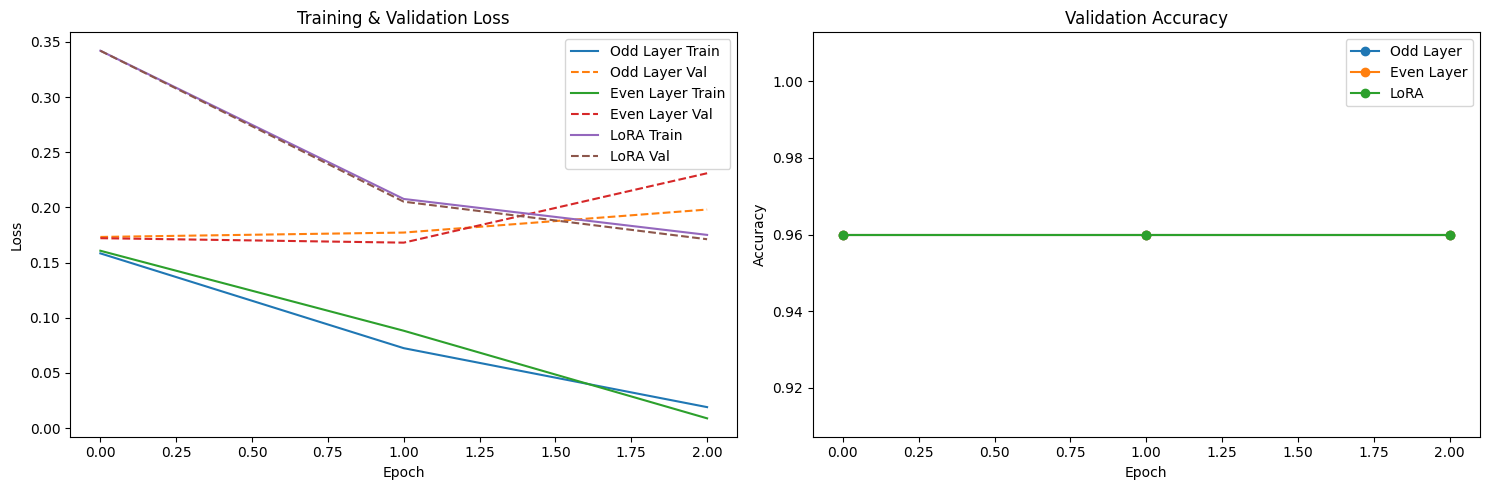

In [14]:
plot_metrics(all_metrics)

In [15]:
# Save the odd-layer student model
odd_model.save_pretrained("./odd_student_model")
tokenizer.save_pretrained("./odd_student_model")

('./odd_student_model\\tokenizer_config.json',
 './odd_student_model\\special_tokens_map.json',
 './odd_student_model\\vocab.txt',
 './odd_student_model\\added_tokens.json',
 './odd_student_model\\tokenizer.json')